In [1]:
import datetime
import time
import json
import os
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
mode = 'bc'
if (mode == 'bc'):
    os.environ['PYSPARK_PYTHON'] = './python3.6.2/bin/python'
    os.environ['HADOOP_USER_NAME'] = 'bigdata_driver_ecosys_test'
    os.environ['HADOOP_USER_PASSWORD'] = '42gdaTh6voXDV0mR2glhNPjWqBxYe22N'
    import findspark
    findspark.init()
    from pyspark import *
    from pyspark.sql import *
    app_name = 'xuyunqing'
    conf = (SparkConf().setAppName(app_name)
            .set('spark.master', 'yarn')
            .set('spark.submit.deployMode', 'client')
            .set('spark.driver.memory',                  '4g')
            .set('spark.executor.memory',                '12g')
            .set('spark.dynamicAllocation.minExecutors', '10')
            .set('spark.driver.maxResultSize' ,           '0')
            .set('spark.dynamicAllocation.maxExecutors', '200')
            .set('spark.yarn.queue',                     'root.kg_novel_dev')
            .set('spark.ui.port','8060')
            .set('spark.yarn.executor.memoryOverhead','3000m')
            .set('spark.yarn.dist.archives','hdfs://DClusterNmg4/user/bigdata_driver_ecosys_test/ly/python_env/python3.6.2.tgz#python3.6.2 ')
            .set('spark.pyspark.driver.python',          './python3.6.2/bin/python')
            .set('spark.pyspark.python', './python3.6.2/bin/python')
            .set("spark.yarn.appMasterEnv.PYSPARK_PYTHON", './python3.6.2/bin/python')
            )
    spark = SparkSession.builder.config(conf = conf).enableHiveSupport().getOrCreate()
    # spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
    sc = spark.sparkContext
from pyspark.sql.functions import col,udf,date_sub,explode,split,date_add
from pyspark.sql.types import StringType,DoubleType,IntegerType
import pandas as pd
import numpy as np
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('expand_frame_repr',False)
from pyspark.sql import functions as F
hc = HiveContext(sc)

In [3]:
label_df = hc.sql('''
select  group_name
		,city_id
		,is_blank
		,product_line
		,group_usr_num
		,gmv
		,subsidy_hufan
		,subsidy_coupon
		,subsidy_c
		,bubble_cnt
		,compete_call_cnt
		,objective_call_cnt
		,business_profit
		,online_driver_divide
		,suc_cnt
        ,dt
from	smt_stg.budget_allocation_xfk_city_daily_table
where group_name in ('rgroup_joint_exp_pack','rgroup_joint_blank')
          and product_line = '新泛快'
          and dt between '2023-05-06' and "2023-05-31"
''').toPandas()

In [70]:
kanban_df = hc.sql('''
select  city_id
		,city_name
		,city_type
		,gmv_type
		,demand
		,source_type
		,err_type
		,gmv
		,exp_cr
		,fkhf
		,pred_gmv
		,target_fkhf
		,obj_cr
		,pred_obj_cr
		,cr_diff
		,fkhf_diff
		,diag1
		,diag2
		,diag3
		,diag4
		,pred_roi
		,real_roi
		,obj_cr_diff
		,pred_obj_cr_diff
		,algo_fkhf
		,algo_fkhf_diff
		,algo_err_type
		,case_level
		,is_manual
		,pred_exp_cr
		,pred_exp_cr_diff
		,kt_ratio
		,exp_cr_diag
        ,dt
from	smt_stg.smt_err_budget_alloc_city_t1
where   dt between '2023-05-06' and "2023-05-31"
''').toPandas()

In [55]:
def cal_roi(label_df):
    label_df['pp_gmv'] = label_df['gmv']/label_df['group_usr_num']
    label_df['pp_subsidy_hufan'] = label_df['subsidy_hufan']/label_df['group_usr_num']
    label_df['pp_subsidy_c'] = label_df['subsidy_c']/label_df['group_usr_num']
    label_df['pp_bp'] = label_df['business_profit']/label_df['group_usr_num']
    label_df['subsidy_hufan_rate'] = label_df['subsidy_hufan']/label_df['gmv']
    label_df['subsidy_c_rate'] = label_df['subsidy_c']/label_df['gmv']
    label_df['bp_rate'] = label_df['business_profit']/label_df['gmv']
    label_df['obj_cr'] = label_df['suc_cnt']/label_df['objective_call_cnt']
    exp_label_df = label_df.query('is_blank == 0')
    blank_label_df = label_df.query('is_blank == 1')
    exp_blank_df = pd.merge(exp_label_df,blank_label_df,on = ['city_id','dt'],suffixes = ('_exp','_blank'))
    exp_blank_df['hufan_roi'] = (exp_blank_df['pp_gmv_exp'] - exp_blank_df['pp_gmv_blank']) / (exp_blank_df['pp_subsidy_hufan_exp'] - exp_blank_df['pp_subsidy_hufan_blank'])
    exp_blank_df['c_roi'] = (exp_blank_df['pp_gmv_exp'] - exp_blank_df['pp_gmv_blank']) / (exp_blank_df['pp_subsidy_c_exp'] - exp_blank_df['pp_subsidy_c_blank'])
    exp_blank_df['bp_roi'] = (exp_blank_df['pp_gmv_exp'] - exp_blank_df['pp_gmv_blank']) / (exp_blank_df['pp_bp_blank'] - exp_blank_df['pp_bp_exp'])
    return exp_blank_df

In [57]:
city_daily_df = cal_roi(label_df)
city_df = label_df.groupby(['is_blank','dt'])[['gmv','group_usr_num','subsidy_hufan','subsidy_c','business_profit','suc_cnt','objective_call_cnt']].agg('sum').reset_index()
city_df['city_id'] = -1
daily_df =  cal_roi(city_df)
city_daily_df_2 = pd.concat([city_daily_df,daily_df])

In [71]:
city_daily_df_3 = pd.merge(city_daily_df_2,kanban_df,on = ['city_id','dt'],how = 'left')

In [74]:
top_city_list = [ 13,  47, 154,   8,  21,   7,   9,   1,  86,  38,  44,  22,  35,
        15, 158,  39,  20,  32,  88,  14, 160, 102,  45,  25,  85,  33,
        82,  89,  34, 153,  23, 133, 157,  26,  36, 132,  16]

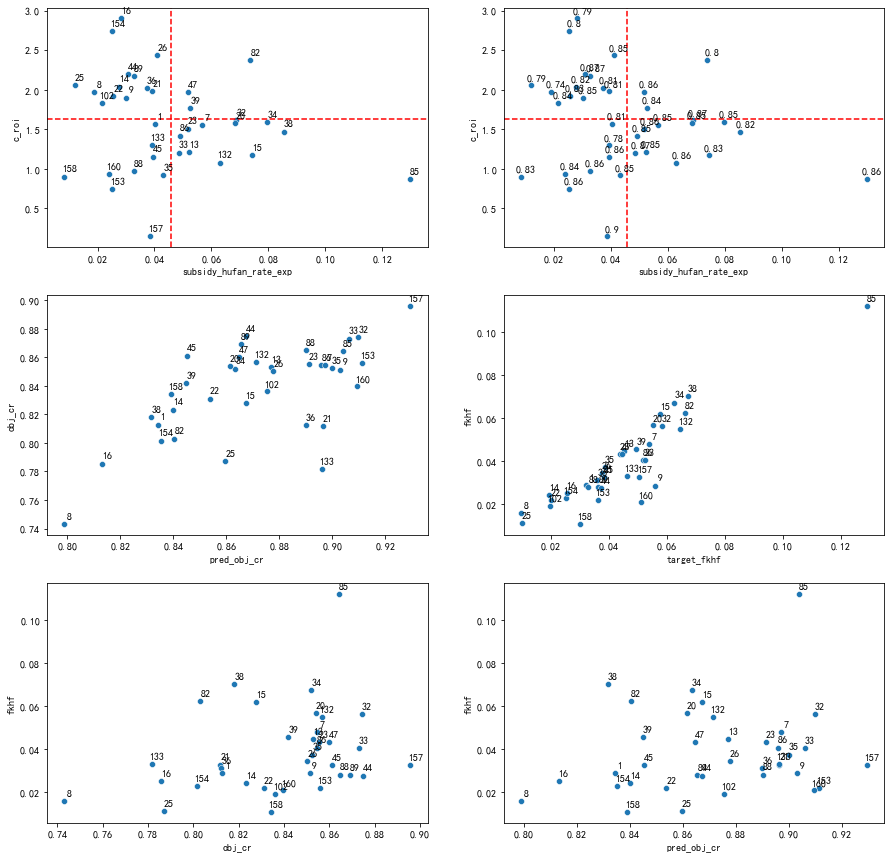

In [224]:
import matplotlib.pyplot as plt
data = city_daily_df_3.query('dt == "2023-05-24" and c_roi >= 0')
# 创建散点图
fig, axis = plt.subplots(3,2, figsize = (15, 15))
sns.scatterplot(data=data.query('city_id in @top_city_list '), x='subsidy_hufan_rate_exp', y='c_roi', ax=axis[0,0])

# 添加城市ID标签
for index, row in data.query('city_id in @top_city_list').iterrows():
   axis[0,0].annotate(row['city_id'], (row['subsidy_hufan_rate_exp'], row['c_roi']), textcoords="offset points", xytext=(5, 5), ha='center')
# 绘制 y = 1 的水平线
axis[0,0].axhline(y=data.query('city_id == -1')['c_roi'].values[0], color='red', linestyle='--')
axis[0,0].axvline(x=data.query('city_id == -1')['subsidy_hufan_rate_exp'].values[0], color='red', linestyle='--')


sns.scatterplot(data=data.query('city_id in @top_city_list '), x='subsidy_hufan_rate_exp', y='c_roi', ax=axis[0,1])

# 添加城市ID标签
for index, row in data.query('city_id in @top_city_list').iterrows():
   axis[0,1].annotate(round(row['obj_cr'],2), (row['subsidy_hufan_rate_exp'], row['c_roi']), textcoords="offset points", xytext=(5, 5), ha='center')
axis[0,1].axhline(y=data.query('city_id == -1')['c_roi'].values[0], color='red', linestyle='--')
axis[0,1].axvline(x=data.query('city_id == -1')['subsidy_hufan_rate_exp'].values[0], color='red', linestyle='--')


sns.scatterplot(data=data.query('city_id in @top_city_list '), x='pred_obj_cr', y='obj_cr', ax=axis[1,0])
# 添加城市ID标签
for index, row in data.query('city_id in @top_city_list').iterrows():
   axis[1,0].annotate(row['city_id'], (row['pred_obj_cr'], row['obj_cr']), textcoords="offset points", xytext=(5, 5), ha='center')



sns.scatterplot(data=data.query('city_id in @top_city_list '), x='target_fkhf', y='fkhf', ax=axis[1,1])
# 添加城市ID标签
for index, row in data.query('city_id in @top_city_list').iterrows():
   axis[1,1].annotate(row['city_id'], (row['target_fkhf'], row['fkhf']), textcoords="offset points", xytext=(5, 5), ha='center')


sns.scatterplot(data=data.query('city_id in @top_city_list '), x='obj_cr', y='fkhf', ax=axis[2,0])
# 添加城市ID标签
for index, row in data.query('city_id in @top_city_list').iterrows():
   axis[2,0].annotate(row['city_id'], (row['obj_cr'], row['fkhf']), textcoords="offset points", xytext=(5, 5), ha='center')


sns.scatterplot(data=data.query('city_id in @top_city_list '), x='pred_obj_cr', y='fkhf', ax=axis[2,1])
# 添加城市ID标签
for index, row in data.query('city_id in @top_city_list').iterrows():
   axis[2,1].annotate(row['city_id'], (row['pred_obj_cr'], row['fkhf']), textcoords="offset points", xytext=(5, 5), ha='center')

# 显示图形
plt.show()

In [385]:
city_daily_df_3

,group_name_exp,city_id,is_blank_exp,product_line_exp,group_usr_num_exp,gmv_exp,subsidy_hufan_exp,subsidy_coupon_exp,subsidy_c_exp,bubble_cnt_exp,compete_call_cnt_exp,objective_call_cnt_exp,business_profit_exp,online_driver_divide_exp,suc_cnt_exp,dt,pp_gmv_exp,subsidy_hufan_rate_exp,subsidy_c_rate_exp,bp_rate_exp,pp_subsidy_hufan_exp,pp_subsidy_c_exp,pp_bp_exp,pp_subsidy_hufan_rate_exp,pp_subsidy_c_rate_exp,pp_bp_rate_exp,obj_cr_exp,group_name_blank,is_blank_blank,product_line_blank,group_usr_num_blank,gmv_blank,subsidy_hufan_blank,subsidy_coupon_blank,subsidy_c_blank,bubble_cnt_blank,compete_call_cnt_blank,objective_call_cnt_blank,business_profit_blank,online_driver_divide_blank,suc_cnt_blank,pp_gmv_blank,subsidy_hufan_rate_blank,subsidy_c_rate_blank,bp_rate_blank,pp_subsidy_hufan_blank,pp_subsidy_c_blank,pp_bp_blank,pp_subsidy_hufan_rate_blank,pp_subsidy_c_rate_blank,pp_bp_rate_blank,obj_cr_blank,hufan_roi,c_roi,bp_roi,city_name,city_type,gmv_type,demand,source_type,err_type,gmv,exp_cr,fkhf,pred_gmv,target_fkhf,obj_cr,pred_obj_cr,cr_diff,fkhf_diff,diag1,diag2,diag3,diag4,pred_roi,real_roi,obj_cr_diff,pred_obj_cr_diff,algo_fkhf,algo_fkhf_diff,algo_err_type,case_level,is_manual,pred_exp_cr,pred_exp_cr_diff,kt_ratio,exp_cr_diag
0,rgroup_joint_exp_pack,14,0,新泛快,227514,2.960552e+06,4429.61,250567.37,2.964943e+05,1131112.0,217110.0,188038.0,2.719558e+05,2.175291e+06,167739.0,2023-05-11,13.012616,0.001496,0.100148,0.091860,0.019470,1.303191,1.195336,0.001496,0.100148,0.091860,0.892048,rgroup_joint_blank,1,新泛快,6294,81977.67,3.56,6713.87,7952.0157,31317.0,5914.0,5119.0,7.598865e+03,60412.228514,4550.0,13.024733,0.000043,0.097002,0.092694,0.000566,1.263428,1.207319,0.000043,0.097002,0.092694,0.888845,-0.640953,-0.304717,-1.011195,大连市,非战区非下沉,大城市,供需均衡,后验,正常,3697980.73,0.937463,0.002277,3.609331e+06,0.000000e+00,0.844741,0.744544,0.001737,-0.950442,0.0,0.0,0.0,0.0,25.566433,-0.304717,-0.014917,-0.144398,0.001310,-0.968045,正常,/,0.0,0.0,NaN,0.956144,0.0
1,rgroup_joint_exp_pack,360,0,新泛快,4701,1.222643e+05,11584.08,15791.11,1.735993e+04,22790.0,5442.0,5403.0,1.024755e+04,9.100932e+04,4329.0,2023-05-11,26.008141,0.094746,0.141987,0.083815,2.464174,3.692816,2.179866,0.094746,0.141987,0.083815,0.801222,rgroup_joint_blank,1,新泛快,269,7267.32,3.85,332.13,399.9700,1214.0,279.0,279.0,1.099745e+03,5527.620000,240.0,27.016059,0.000530,0.055037,0.151327,0.014312,1.486877,4.088272,0.000530,0.055037,0.151327,0.860215,-0.411419,-0.456911,-0.528147,陵水黎族自治县,非战区非下沉,尾部城市,缺供给,后验,正常,162828.92,0.885114,0.087290,1.673583e+05,2.904899e-02,0.796391,0.816148,0.053740,3.097918,0.0,0.0,0.0,0.0,0.989067,-0.456911,0.078370,0.192460,0.118842,5.105645,正常,/,0.0,0.0,NaN,0.813612,0.0
2,rgroup_joint_exp_pack,157,0,新泛快,65087,1.076912e+06,54702.92,101276.01,1.380409e+05,309149.0,83536.0,81115.0,1.358023e+05,7.545903e+05,75210.0,2023-05-11,16.545733,0.050796,0.128182,0.126103,0.840458,2.120868,2.086474,0.050796,0.128182,0.126103,0.927202,rgroup_joint_blank,1,新泛快,3712,58092.36,43.25,3099.55,5113.7376,17087.0,4573.0,4427.0,8.856789e+03,41415.080000,4135.0,15.649881,0.000745,0.088028,0.152460,0.011651,1.377623,2.385988,0.000745,0.088028,0.152460,0.934041,1.080893,1.205325,2.991011,清远市,非战区非下沉,中城市,严重缺需求,后验,正常,1374322.58,0.955939,0.050943,1.181138e+06,4.598805e-02,0.891398,0.930849,0.021480,0.108807,0.0,0.0,0.0,0.0,1.378444,1.205325,0.039492,0.069696,0.041399,0.009807,正常,/,0.0,0.0,NaN,0.853498,0.0
3,rgroup_joint_exp_pack,54,0,新泛快,38948,5.205172e+05,12764.07,45990.97,5.832423e+04,173741.0,43977.0,38198.0,4.154018e+04,3.892200e+05,33531.0,2023-05-11,13.364414,0.024522,0.112051,0.079806,0.327721,1.497490,1.066555,0.024522,0.112051,0.079806,0.877821,rgroup_joint_blank,1,新泛快,1088,14192.32,4.38,1135.56,1432.7506,4918.0,1208.0,1048.0,1.016973e+03,10754.510000,945.0,13.044412,0.000309,0.100953,0.071657,0.004026,1.316866,0.934718,0.000309,0.100953,0.071657,0.901718,0.988593,1.771655,-2.427264,株洲市,非战区非下沉,小城市,缺需求,后验,正常,660229.03,0.916396,0.022831,6.620155e+05,0.000000e+00,0.837512,0.765008,0.0909

In [593]:
# 读入模拟分配结果  列名分别为'city_id','dt','exp_pkhf','exp_thhf','exp_fkhf'
#mps_exp2_df = pd.read_csv('../mps_exp_2/mps_2_exp_result.csv')[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]
#mps_exp2_df = pd.read_csv('multi_funnel_same_dsend_two_stage_result_0522_0528.csv')[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]
#mps_exp2_df = pd.read_csv('abtest_1.5_result_0522_0528.csv')[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]
#mps_exp2_df = pd.read_csv('nn1.csv').rename(columns = {'stat_date':'dt','kc_subsidy_rate':'exp_pkhf','th_subsidy_rate':'exp_thhf','crate':'exp_fkhf'})[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]
#mps_exp2_df = city_daily_df_3[['city_id','dt','target_fkhf']].rename(columns = {'target_fkhf':'exp_fkhf'})
#mps_exp2_df = pd.read_csv('nn2_without_ecr.csv').rename(columns = {'stat_date':'dt','kc_subsidy_rate':'exp_pkhf','th_subsidy_rate':'exp_thhf','crate':'exp_fkhf'})[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]
mps_exp2_df = pd.read_csv('nn2_d_cr.csv').rename(columns = {'stat_date':'dt','kc_subsidy_rate':'exp_pkhf','th_subsidy_rate':'exp_thhf','crate':'exp_fkhf'})[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]

# 计算和线上分配比加减前幅度
city_daily_df_4 = pd.merge(city_daily_df_3,mps_exp2_df,on = ['city_id','dt'],how = 'left')
city_daily_df_4['fk_hf_diff'] = city_daily_df_4['exp_fkhf'] - city_daily_df_4['subsidy_hufan_rate_exp']
city_daily_df_4['fk_hf_diff'] = city_daily_df_4['fk_hf_diff'].fillna(0)

start_date = '2023-05-22'
end_date = '2023-05-28'
date_list = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m-%d').tolist()

country_data = city_daily_df_4.query('city_id == -1')[['dt','c_roi','subsidy_hufan_rate_exp']].rename(columns = {'c_roi':'country_roi','subsidy_hufan_rate_exp':'country_hufan_rate'})
city_daily_df_5 = pd.merge(city_daily_df_4,country_data,on = ['dt'],how = 'left')
city_daily_df_5['day'] = city_daily_df_5['dt']
city_daily_df_5['key'] = city_daily_df_5.apply(lambda x: str(x.city_id)+'_'+ str(x.day), axis = 1)

add_money_df = city_daily_df_5.query('(city_id in @top_city_list and dt in @date_list and c_roi > 1.5*country_roi and subsidy_hufan_rate_exp <= 0.03) or (city_id in @top_city_list and dt in @date_list and c_roi > 1.4*country_roi and subsidy_hufan_rate_exp > 0.03) ')
sub_money_df = city_daily_df_5.query('city_id in @top_city_list and dt in @date_list and (c_roi <= 1 or c_roi <= 0.6*country_roi) and subsidy_hufan_rate_exp >= 0.01')
key_list = list(set(add_money_df['key'].unique()).union(set(sub_money_df['key'].unique())))
nor_money_df = city_daily_df_5.query('city_id in @top_city_list and dt in @date_list and key not in @key_list')
add_money_df['is_right'] = add_money_df.apply(lambda x: 1 if x.fk_hf_diff > 0.005 else (-1 if x.fk_hf_diff < -0.005 else 0),axis = 1)
sub_money_df['is_right'] = sub_money_df.apply(lambda x: 1 if x.fk_hf_diff < -0.005 else (-1 if x.fk_hf_diff > 0.005 else 0),axis = 1)

/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'roi低的城市（应该减钱）')

/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/luban/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


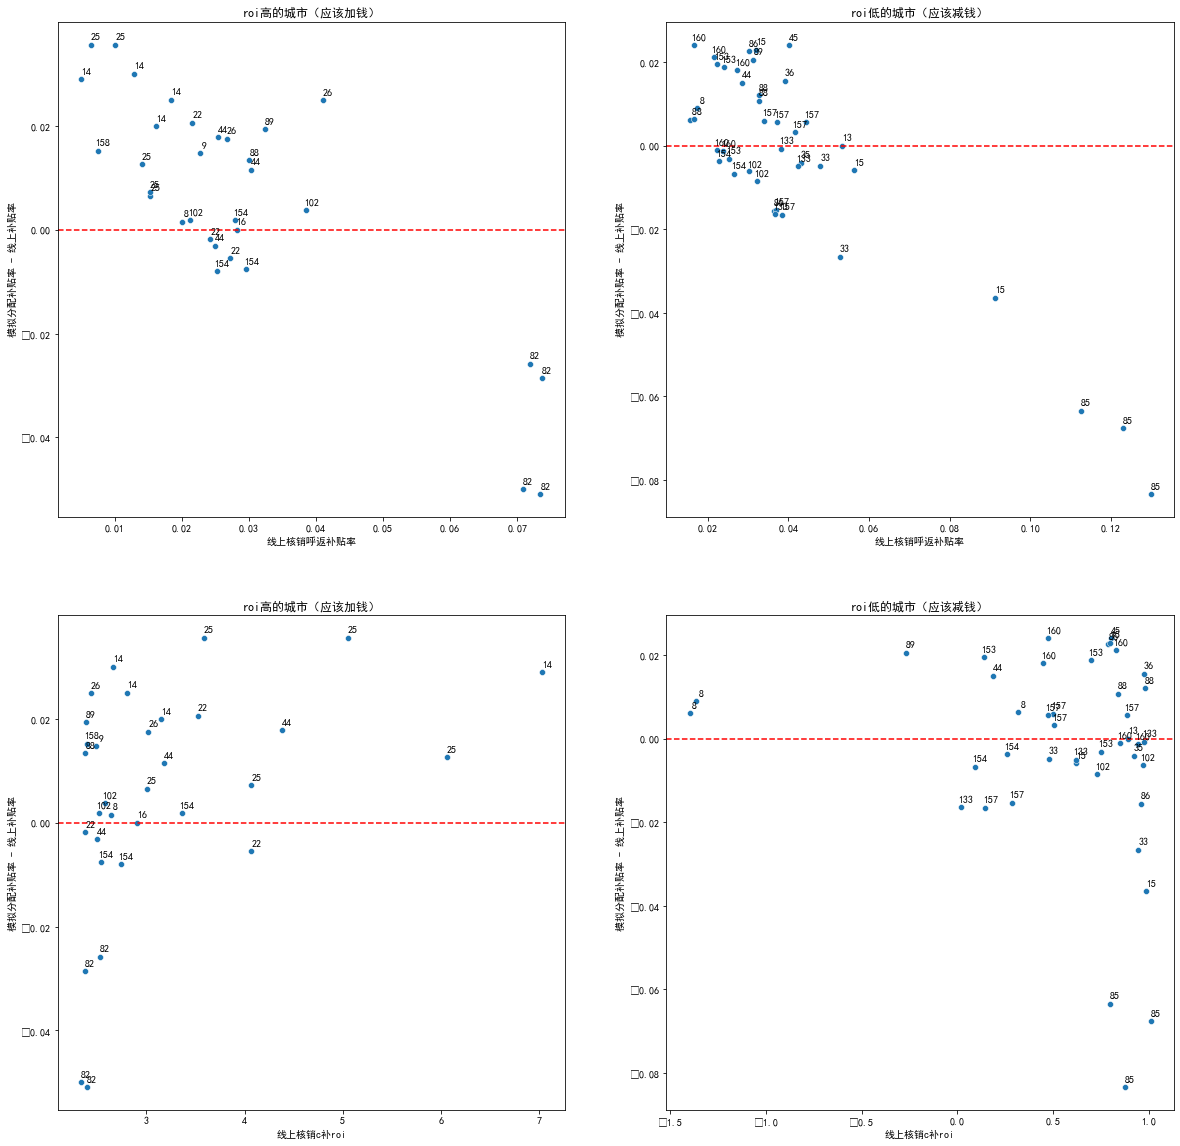

In [594]:
fig, axis = plt.subplots(2,2, figsize = (20, 20))
sns.scatterplot(data=add_money_df, x='subsidy_hufan_rate_exp', y='fk_hf_diff', ax=axis[0,0])
# 添加城市ID标签
for index, row in add_money_df.iterrows():
   axis[0,0].annotate(row['city_id'], (row['subsidy_hufan_rate_exp'], row['fk_hf_diff']), textcoords="offset points", xytext=(5, 5), ha='center')
# 绘制 y = 1 的水平线
axis[0,0].axhline(y=0, color='red', linestyle='--')
# 重新命名横坐标、纵坐标和标题
axis[0, 0].set_xlabel('线上核销呼返补贴率')
axis[0, 0].set_ylabel('模拟分配补贴率 - 线上补贴率')
axis[0, 0].set_title('roi高的城市（应该加钱）')

sns.scatterplot(data=sub_money_df, x='subsidy_hufan_rate_exp', y='fk_hf_diff', ax=axis[0,1])
for index, row in sub_money_df.iterrows():
   axis[0,1].annotate(row['city_id'], (row['subsidy_hufan_rate_exp'], row['fk_hf_diff']), textcoords="offset points", xytext=(5, 5), ha='center')
# 绘制 y = 1 的水平线
axis[0,1].axhline(y=0, color='red', linestyle='--')
axis[0, 1].set_xlabel('线上核销呼返补贴率')
axis[0, 1].set_ylabel('模拟分配补贴率 - 线上补贴率')
axis[0, 1].set_title('roi低的城市（应该减钱）')

sns.scatterplot(data=add_money_df, x='c_roi', y='fk_hf_diff', ax=axis[1,0])
# 添加城市ID标签
for index, row in add_money_df.iterrows():
   axis[1,0].annotate(row['city_id'], (row['c_roi'], row['fk_hf_diff']), textcoords="offset points", xytext=(5, 5), ha='center')
# 绘制 y = 1 的水平线
axis[1,0].axhline(y=0, color='red', linestyle='--')
axis[1, 0].set_xlabel('线上核销c补roi')
axis[1, 0].set_ylabel('模拟分配补贴率 - 线上补贴率')
axis[1, 0].set_title('roi高的城市（应该加钱）')


sns.scatterplot(data=sub_money_df, x='c_roi', y='fk_hf_diff', ax=axis[1,1])
for index, row in sub_money_df.iterrows():
   axis[1,1].annotate(row['city_id'], (row['c_roi'], row['fk_hf_diff']), textcoords="offset points", xytext=(5, 5), ha='center')
# 绘制 y = 1 的水平线
axis[1,1].axhline(y=0, color='red', linestyle='--')
axis[1, 1].set_xlabel('线上核销c补roi')
axis[1, 1].set_ylabel('模拟分配补贴率 - 线上补贴率')
axis[1, 1].set_title('roi低的城市（应该减钱）')

In [595]:
print('-'*20)
print('理想加钱实际加钱的数量：',add_money_df.query('is_right == 1 ').shape[0],'平均加钱幅度：',round(add_money_df.query('is_right == 1')['fk_hf_diff'].mean(),2),'加钱预算为:',round((add_money_df.query('is_right == 1')['fk_hf_diff'] * add_money_df.query('is_right == 1')['gmv_exp']).sum() ,2))
print('理想加钱实际减钱的数量：',add_money_df.query('is_right == -1 ').shape[0],'平均减钱幅度：',round(add_money_df.query('is_right == -1')['fk_hf_diff'].mean(),2),'减钱预算为:',round((add_money_df.query('is_right == -1')['fk_hf_diff'] * add_money_df.query('is_right == -1')['gmv_exp']).sum() ,2))

print('-'*20)
print('理想减钱实际减钱的数量：',sub_money_df.query('is_right == 1').shape[0],'平均减钱幅度：',round(sub_money_df.query('is_right == 1')['fk_hf_diff'].mean(),2),'减钱预算为:',round((sub_money_df.query('is_right == 1')['fk_hf_diff'] * sub_money_df.query('is_right == 1')['gmv_exp']).sum() ,2))
print('理想减钱实际加钱的数量：',sub_money_df.query('is_right == -1').shape[0],'平均加钱幅度：',round(sub_money_df.query('is_right == -1')['fk_hf_diff'].mean(),2),'加钱预算为:',round((sub_money_df.query('is_right == -1')['fk_hf_diff'] * sub_money_df.query('is_right == -1')['gmv_exp']).sum() ,2))

print('-'*20)

print('加钱方向正确的比例：',round(add_money_df.query('is_right == 1').shape[0]/add_money_df.shape[0],2),'gmv加权加钱方向正确的比例：',round((add_money_df.query('is_right == 1')['is_right'] * add_money_df.query('is_right == 1')['gmv_exp']).sum()/(add_money_df['gmv_exp']).sum(),2))
print('减钱方向正确的比例：',round(sub_money_df.query('is_right == 1').shape[0]/sub_money_df.shape[0],2),'gmv加权减钱方向正确的比例：',round((sub_money_df.query('is_right == 1')['is_right'] * sub_money_df.query('is_right == 1')['gmv_exp']).sum()/(sub_money_df['gmv_exp']).sum(),2))

print('-'*20)
print('平均加钱幅度：',round(add_money_df['fk_hf_diff'].mean(),3),'gmv加权的平均加钱幅度：',round((add_money_df['fk_hf_diff']*add_money_df['gmv_exp']).sum()/(add_money_df['gmv_exp']).sum(),3),'补贴加权的平均加钱幅度：',round((add_money_df['fk_hf_diff']*add_money_df['exp_fkhf']*add_money_df['gmv_exp']).sum()/(add_money_df['exp_fkhf']*add_money_df['gmv_exp']).sum(),3))
print('平均减钱幅度：',round(sub_money_df['fk_hf_diff'].mean(),3),'gmv加权的平均减钱幅度：',round((sub_money_df['fk_hf_diff']*sub_money_df['gmv_exp']).sum()/(sub_money_df['gmv_exp']).sum(),3),'补贴加权的平均减钱幅度：',round((sub_money_df['fk_hf_diff']*sub_money_df['exp_fkhf']*sub_money_df['gmv_exp']).sum()/(sub_money_df['exp_fkhf']*sub_money_df['gmv_exp']).sum(),3))

print('-'*20)
print('线上分配合理城市，新分配方案补贴占比',round((nor_money_df['fkhf'] * nor_money_df['pred_gmv']).sum()/(city_daily_df_5.query('city_id in @top_city_list and dt in @date_list')['fkhf'] * city_daily_df_5.query('city_id in @top_city_list and dt in @date_list')['pred_gmv']).sum(),2))
print('线上分配合理城市,新分配方案与核销分配gap在1pp补贴率以内补贴占比',round((nor_money_df.query('abs(fk_hf_diff) < 0.01')['fkhf'] * nor_money_df.query('abs(fk_hf_diff) < 0.01')['pred_gmv']).sum()/(city_daily_df_5.query('city_id in @top_city_list and dt in @date_list')['fkhf'] * city_daily_df_5.query('city_id in @top_city_list and dt in @date_list')['pred_gmv']).sum(),2))
print('线上分配合理城市，新分配方案与核销分配gap在2pp补贴率以内补贴占比',round((nor_money_df.query('abs(fk_hf_diff) < 0.02')['fkhf'] * nor_money_df.query('abs(fk_hf_diff) < 0.02')['pred_gmv']).sum()/(city_daily_df_5.query('city_id in @top_city_list and dt in @date_list')['fkhf'] * city_daily_df_5.query('city_id in @top_city_list and dt in @date_list')['pred_gmv']).sum(),2))

--------------------
理想加钱实际加钱的数量： 18 平均加钱幅度： 0.02 加钱预算为: 705188.76
理想加钱实际减钱的数量： 7 平均减钱幅度： -0.03 减钱预算为: -350803.73
--------------------
理想减钱实际减钱的数量： 14 平均减钱幅度： -0.03 减钱预算为: -1143985.61
理想减钱实际加钱的数量： 19 平均加钱幅度： 0.01 加钱预算为: 528122.01
--------------------
加钱方向正确的比例： 0.56 gmv加权加钱方向正确的比例： 0.64
减钱方向正确的比例： 0.33 gmv加权减钱方向正确的比例： 0.4
--------------------
平均加钱幅度： 0.006 gmv加权的平均加钱幅度： 0.007 补贴加权的平均加钱幅度： 0.01
平均减钱幅度： -0.003 gmv加权的平均减钱幅度： -0.008 补贴加权的平均减钱幅度： -0.008
--------------------
线上分配合理城市，新分配方案补贴占比 0.86
线上分配合理城市,新分配方案与核销分配gap在1pp补贴率以内补贴占比 0.44
线上分配合理城市，新分配方案与核销分配gap在2pp补贴率以内补贴占比 0.59


In [560]:
mps_exp2_df = pd.read_csv('nn2.csv').rename(columns = {'stat_date':'dt','kc_subsidy_rate':'exp_pkhf','th_subsidy_rate':'exp_thhf','crate':'exp_fkhf'})[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]
mps_exp2_df_2 = pd.read_csv('nn2_without_ecr.csv').rename(columns = {'stat_date':'dt','kc_subsidy_rate':'exp_pkhf','th_subsidy_rate':'exp_thhf','crate':'exp_fkhf'})[['city_id','dt','exp_pkhf','exp_thhf','exp_fkhf']]

In [521]:
mps_df_df = pd.merge(mps_exp2_df,mps_exp2_df_2,on = ['dt','city_id'],suffixes =("_nn","_no_ecr"),how = 'left')

In [576]:
mps_df_df['diff'] = mps_df_df['exp_fkhf_nn'] - mps_df_df['exp_fkhf_no_ecr']
mps_df_df = pd.merge(mps_df_df,kanban_df,on = ['dt','city_id'],how = 'left')

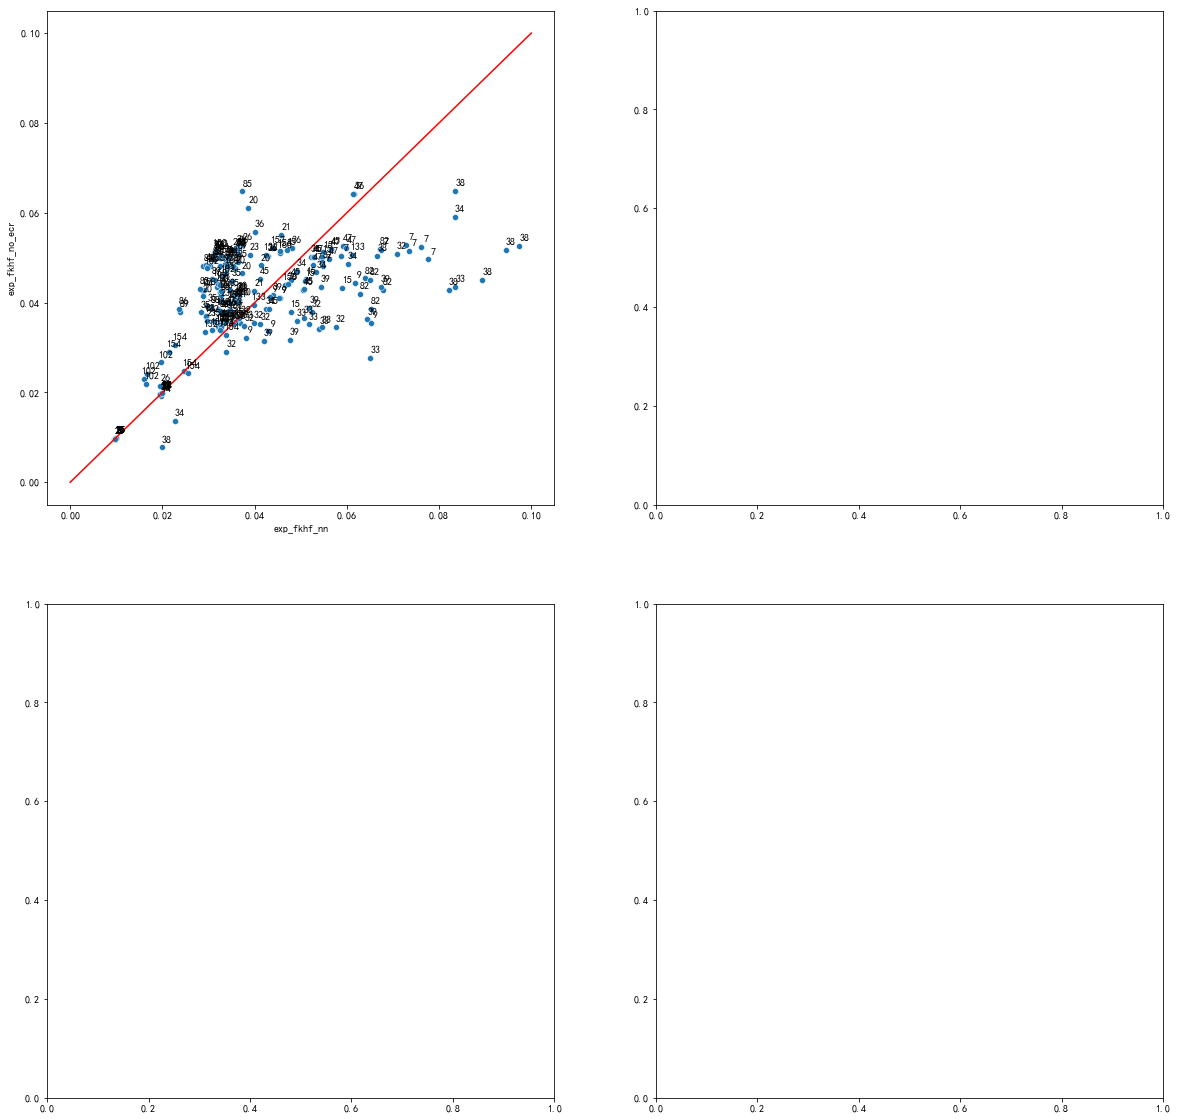

In [577]:
fig, axis = plt.subplots(2,2, figsize = (20, 20))
sns.scatterplot(data=mps_df_df.query('city_id in @top_city_list'), x='exp_fkhf_nn', y='exp_fkhf_no_ecr', ax=axis[0,0])
axis[0,0].plot([0,0.1],[0,0.1],c = 'r')
# 添加城市ID标签
for index, row in mps_df_df.query('city_id in @top_city_list').iterrows():
   axis[0,0].annotate(row['city_id'], (row['exp_fkhf_nn'], row['exp_fkhf_no_ecr']), textcoords="offset points", xytext=(5, 5), ha='center')
plt.show()

In [578]:
mps_df_df.query('city_id in @top_city_list and diff > 0.01').sort_values(['diff'],ascending = False)

,city_id,dt,exp_pkhf_nn,exp_thhf_nn,exp_fkhf_nn,exp_pkhf_no_ecr,exp_thhf_no_ecr,exp_fkhf_no_ecr,diff,city_name,city_type,gmv_type,demand,source_type,err_type,gmv,exp_cr,fkhf,pred_gmv,target_fkhf,obj_cr,pred_obj_cr,cr_diff,fkhf_diff,diag1,diag2,diag3,diag4,pred_roi,real_roi,obj_cr_diff,pred_obj_cr_diff,algo_fkhf,algo_fkhf_diff,algo_err_type,case_level,is_manual,pred_exp_cr,pred_exp_cr_diff,kt_ratio,exp_cr_diag
281,38,2023-05-23,0.070004,0.170011,0.097374,0.007,0.130000,0.052530,0.044843,南昌市,非战区非下沉,中城市,严重缺需求,后验,中等误补,2201884.40,0.911784,0.064002,2.288266e+06,0.059633,0.793549,0.853098,-0.022328,1.020592,0,1,1,1,0.876107,1.817717,-0.062395,0.000676,0.097505,1.872379,中等误补,P2,0,0.0,NaN,0.846293,0
546,38,2023-05-24,0.009000,0.210001,0.089389,0.001,0.110006,0.045126,0.044263,南昌市,非战区非下沉,中城市,严重缺需求,后验,中等误补,2189170.22,0.925020,0.070215,2.302147e+06,0.067257,0.818091,0.831652,-0.005071,1.155001,0,0,0,0,0.942408,1.469941,-0.038492,-0.041075,0.099744,1.890083,中等误补,P2,0,0.0,NaN,0.836056,0
805,38,2023-05-25,0.030001,0.190007,0.094489,0.001,0.120003,0.051694,0.042795,南昌市,非战区非下沉,中城市,严重缺需求,后验,中等误补,2212296.11,0.922622,0.069293,2.175286e+06,0.070557,0.818724,0.884114,-0.019062,1.282321,0,1,1,1,1.130748,1.420606,-0.040460,0.015531,0.096189,1.740745,中等误补,P2,0,0.0,NaN,0.841094,0
1585,33,2023-05-28,0.007001,0.140014,0.083503,0.000,0.075001,0.043551,0.039951,南宁市,非战区非下沉,大城市,严重缺需求,后验,正常,3578043.77,0.941086,0.047636,3.597128e+06,0.099215,0.864506,0.865841,0.025663,0.231394,0,0,0,0,0.651429,0.944252,0.061029,0.093723,0.097639,1.711090,正常,/,0,0.0,NaN,0.898845,0
20,38,2023-05-22,0.003000,0.200003,0.082160,0.001,0.105003,0.042871,0.039289,南昌市,非战区非下沉,中城市,严重缺需求,后验,正常,2234191.52,0.922010,0.055795,2.141541e+06,0.053885,0.819867,0.833411,0.000698,0.929814,0,0,0,0,1.071534,1.842389,-0.004857,-0.015036,0.082160,1.843887,正常,/,0,0.0,NaN,0.858911,0
1325,33,2023-05-27,0.006000,0.125006,0.065082,0.000,0.055004,0.027755,0.037326,南宁市,非战区非下沉,大城市,严重缺需求,后验,正常,3950431.65,0.941669,0.048617,4.365357e+06,0.071755,0.868861,0.779384,0.026299,0.369100,0,0,0,0,0.911721,1.355851,0.062470,-0.048141,0.065084,1.233644,正常,/,0,0.0,NaN,0.899969,0
1081,9,2023-05-26,0.006000,0.150009,0.065202,0.000,0.085004,0.035422,0.029780,郑州市,非战区非下沉,大城市,供需双缺,后验,严重误补,5461670.05,0.862042,0.022303,5.122033e+06,0.003141,0.716378,0.150101,-0.053089,-0.307985,0,0,0,0,1.725495,2.487983,-0.116164,-0.213025,0.065651,0.982066,严重误补,P0,0,0.0,NaN,0.838011,0
1069,39,2023-05-26,0.000000,0.160010,0.064463,0.000,0.090004,0.036260,0.028202,徐州市,非战区非下沉,中城市,严重缺需求,后验,轻度误补,1615081.46,0.907323,0.046110,1.524164e+06,0.033974,0.800288,0.166350,-0.003350,0.430673,0,0,0,0,0.951556,2.214775,-0.012641,-0.127832,0.090380,1.728663,中等误补,P2,0,0.0,NaN,0.859461,0
27,7,2023-05-22,0.025000,0.130002,0.077661,0.000,0.095003,0.049601,0.028060,天津市,非战区非下沉,大城市,缺需求,后验,中等误补,8239814.59,0.921168,0.043904,8.267677e+06,0.052212,0.824155,0.893995,-0.000215,0.518514,0,1,1,1,1.126257,1.402893,0.000348,0.056565,0.060044,1.078350,中等误补,P1,0,0.0,NaN,0.882402,0
1321,82,2023-05-27,0.006000,0.115005,0.065227,0.000,0.070005,0.038529,0.026698,贵阳市,非战区非下沉,中城市,严重缺需求,后验,中等误补,3241664.72,0.909084,0.074343,3.165475e+06,0.071554,0.798829,0.804032,-0.009213,1.093577,0,0,0,0,1.089906,2.258420,-0.023167,-0.018039,0.093575,2.211414,中等误补,P2,0,0.0,NaN,0.853277,0


In [579]:
mps_df_df.query('city_id in @top_city_list and diff < -0.01').sort_values(['diff'],ascending = True)

,city_id,dt,exp_pkhf_nn,exp_thhf_nn,exp_fkhf_nn,exp_pkhf_no_ecr,exp_thhf_no_ecr,exp_fkhf_no_ecr,diff,city_name,city_type,gmv_type,demand,source_type,err_type,gmv,exp_cr,fkhf,pred_gmv,target_fkhf,obj_cr,pred_obj_cr,cr_diff,fkhf_diff,diag1,diag2,diag3,diag4,pred_roi,real_roi,obj_cr_diff,pred_obj_cr_diff,algo_fkhf,algo_fkhf_diff,algo_err_type,case_level,is_manual,pred_exp_cr,pred_exp_cr_diff,kt_ratio,exp_cr_diag
1582,85,2023-05-28,0.000,0.075008,0.037358,0.000000,0.130002,0.064754,-0.027396,温州市,非战区非下沉,大城市,严重缺需求,后验,正常,5065029.67,0.940927,0.115004,4.320397e+06,0.124527,0.858425,0.857565,0.025489,1.972852,0,0,0,0,1.931447,1.111269,0.053566,0.083269,0.042339,0.175613,正常,/,0,0.0,NaN,0.748988,0
1581,20,2023-05-28,0.002,0.105011,0.038663,0.000000,0.170003,0.061117,-0.022454,宁波市,非战区非下沉,大城市,缺需求,后验,正常,4657802.71,0.931144,0.063924,4.375900e+06,0.065169,0.828561,0.789124,0.014827,0.652441,0,0,0,0,2.309387,1.574122,0.016913,-0.003185,0.043599,0.210583,正常,/,0,0.0,NaN,0.802037,0
1574,158,2023-05-28,0.000,0.125013,0.031343,0.007000,0.190003,0.051473,-0.020129,汕头市,非战区非下沉,中城市,供需均衡,后验,正常,2175094.23,0.895265,0.012886,2.044438e+06,0.026329,0.794346,0.773382,-0.024276,-0.666890,0,0,0,0,2.019271,1.712063,-0.025080,-0.023070,0.026329,-0.268947,正常,/,0,0.0,NaN,0.862009,0
1576,102,2023-05-28,0.000,0.110011,0.031475,0.000000,0.180003,0.051505,-0.020030,赣州市,非战区非下沉,小城市,缺需求,后验,正常,1209722.79,0.899549,0.034398,1.287631e+06,0.031475,0.774613,0.780948,0.083447,0.997630,0,0,0,0,2.953888,1.169055,0.092121,0.300735,0.020030,0.154620,正常,/,0,0.0,NaN,0.868721,0
1575,89,2023-05-28,0.001,0.090009,0.031157,0.000000,0.150003,0.051147,-0.019990,绍兴市,非战区非下沉,中城市,供需均衡,后验,轻度漏补,2282717.44,0.931414,0.032679,2.197467e+06,0.037977,0.825260,0.779065,0.015122,-0.155254,0,0,1,1,2.312045,1.211891,0.012861,-0.015892,0.029452,-0.182209,轻度漏补,P2,0,0.0,NaN,0.859939,0
1579,44,2023-05-28,0.001,0.110011,0.031481,0.001000,0.180003,0.051192,-0.019710,遵义市,非战区非下沉,中城市,严重缺需求,后验,正常,995271.70,0.895929,0.029186,1.030585e+06,0.036605,0.813457,0.761188,-0.023552,-0.245554,0,0,0,0,2.133476,2.012188,-0.001625,-0.038474,0.029566,-0.179067,正常,/,0,0.0,NaN,0.883338,0
1580,86,2023-05-28,0.003,0.060006,0.031343,0.001000,0.100002,0.050708,-0.019365,金华市,非战区非下沉,大城市,供需均衡,后验,正常,4683509.40,0.933350,0.045781,4.322770e+06,0.055358,0.826838,0.763717,0.017231,0.183432,0,1,1,1,2.922735,1.158224,0.014798,-0.035279,0.025163,-0.301321,轻度漏补,/,0,0.0,NaN,0.886739,0
1572,35,2023-05-28,0.000,0.105011,0.031257,0.000000,0.170003,0.050607,-0.019350,泉州市,非战区非下沉,大城市,缺需求,后验,正常,5308891.46,0.915826,0.037017,4.817284e+06,0.029769,0.816105,0.771696,-0.001867,-0.043116,0,0,0,0,1.934814,1.844655,0.001625,-0.025200,0.029769,-0.173429,正常,/,0,0.0,NaN,0.871840,0
1308,85,2023-05-27,0.000,0.060003,0.028894,0.000000,0.100008,0.048156,-0.019262,温州市,非战区非下沉,大城市,严重缺需求,后验,正常,4970050.41,0.944939,0.112965,4.565247e+06,0.120390,0.870305,0.850965,0.029864,2.181241,0,0,0,0,2.662829,1.008522,0.064236,0.039281,0.028895,-0.008356,正常,/,0,0.0,NaN,0.748425,0
1309,44,2023-05-27,0.001,0.090004,0.029487,0.000000,0.150011,0.048285,-0.018797,遵义市,非战区非下沉,中城市,严重缺需求,后验,正常,1074279.85,0.893399,0.028390,9.730483e+05,0.039144,0.811712,0.833734,-0.026309,-0.200491,0,0,0,0,2.467216,3.181093,-0.007413,0.018236,0.027879,-0.043209,正常,/,0,0.0,NaN,0.891988,0


In [167]:
# 模拟计算
import math
x_list = np.arange(0.01,0.11,0.01)
y_list = [0.8*math.sqrt(30*x)/x for x in x_list]
conf_matrix = [[0]*len(x_list) for _ in range(len(x_list))]
for i in range(len(x_list)):
    for j in range(len(x_list)):
        conf = (0.8*math.sqrt(30*x_list[i])/x_list[i])/(0.8*math.sqrt(30*x_list[j])/x_list[j])
        conf_matrix[i][j] = round(conf,2)

In [168]:
conf_matrix

[[1.0, 1.41, 1.73, 2.0, 2.24, 2.45, 2.65, 2.83, 3.0, 3.16],
 [0.71, 1.0, 1.22, 1.41, 1.58, 1.73, 1.87, 2.0, 2.12, 2.24],
 [0.58, 0.82, 1.0, 1.15, 1.29, 1.41, 1.53, 1.63, 1.73, 1.83],
 [0.5, 0.71, 0.87, 1.0, 1.12, 1.22, 1.32, 1.41, 1.5, 1.58],
 [0.45, 0.63, 0.77, 0.89, 1.0, 1.1, 1.18, 1.26, 1.34, 1.41],
 [0.41, 0.58, 0.71, 0.82, 0.91, 1.0, 1.08, 1.15, 1.22, 1.29],
 [0.38, 0.53, 0.65, 0.76, 0.85, 0.93, 1.0, 1.07, 1.13, 1.2],
 [0.35, 0.5, 0.61, 0.71, 0.79, 0.87, 0.94, 1.0, 1.06, 1.12],
 [0.33, 0.47, 0.58, 0.67, 0.75, 0.82, 0.88, 0.94, 1.0, 1.05],
 [0.32, 0.45, 0.55, 0.63, 0.71, 0.77, 0.84, 0.89, 0.95, 1.0]]

In [345]:
mps_exp2_df = pd.read_csv('nn1.csv')

In [384]:
mps_exp2_df.to_csv('out_pus_%s_.csv'%"2023")

In [589]:
mps_exp2_df['bin_val'] = pd.qcut(mps_exp2_df['exp_fkhf'], q=5, labels=False,duplicates='drop')

In [590]:
mps_exp2_df['bin_val'].unique()

array([3, 4, 2, 0, 1])

In [591]:
mps_exp2_df

,city_id,dt,exp_pkhf,exp_thhf,exp_fkhf,bin_val
0,86,2023-05-22,0.000,0.045,0.023541,3
1,153,2023-05-22,0.004,0.055,0.023232,3
2,21,2023-05-22,0.000,0.095,0.034421,4
3,46,2023-05-22,0.000,0.110,0.024421,3
4,88,2023-05-22,0.000,0.105,0.034036,4
...,...,...,...,...,...,...
1783,296,2023-05-28,0.000,0.045,0.014040,2
1784,125,2023-05-28,0.000,0.150,0.056295,4
1785,312,2023-05-28,0.000,0.110,0.014317,2
1786,185,2023-05-28,0.002,0.170,0.042449,4


In [592]:
vev = hc.sql('''
select  city_id
        ,forecast_date as stat_date
        ,cast(sum(if(metric = 'exp_cr_exp_openapi', forecast_value, 0)) as Double) as score
from    mp_data.dm_trip_mkt_supply_demand_forecast_di
where   forecast_date between '2023-05-22' and '2023-05-26'
        and dt = date_sub('2023-05-21', 0) -- 指定的 gmv dt 分区
        and product_id = '110100_110400_110800_110103'
        and city_id in (284,348,105,131,150,306,329,338,33,119,314,323,327,372,28,32,109,140,164,232,57,166,328,351,117,86,174,231,248,266,301,52,68,74,196,219,122,334,8,213,283,45,169,215,145,154,58,67,118,326,359,252,294,343,364,156,220,346,23,138,157,321,333,362,35,254,318,9,64,194,195,297,255,42,65,98,132,149,158,339,128,293,322,180,265,286,205,209,360,303,305,40,73,137,200,249,363,202,270,271,272,311,317,341,26,144,197,269,261,369,91,295,34,82,175,179,253,342,7,47,207,292,63,192,201,238,278,56,206,273,280,330,299,20,55,103,168,242,262,193,239,260,361,365,267,291,366,104,133,190,210,302,354,72,102,120,214,224,107,199,347,153,274,59,198,296,308,340,38,141,162,203,14,77,226,371,246,54,66,125,146,218,276,211,353,124,181,185,258,275,129,247,268,310,315,352,36,78,116,126,256,85,130,216,217,287,290,61,298,313,345,21,96,225,337,349,69,177,281,282,316,368,53,88,277,325,335,178,60,70,89,163,49,222,309,312,324,356,320,30,43,336,76,191,39,71,160,212,15,99,243,367,370,127,148,230,344,350,355,22,171,228,251,332,264,300,25,44,46,75,135,208,331)
group by city_id,forecast_date
''').toPandas()

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



Py4JJavaError: An error occurred while calling o359.collectToPython.
: org.apache.spark.sql.catalyst.errors.package$TreeNodeException: execute, tree:
Exchange(coordinator id: 1140696257) hashpartitioning(city_id#271L, forecast_date#278, 1000), coordinator[target post-shuffle partition size: 67108864]
+- *(1) HashAggregate(keys=[city_id#271L, forecast_date#278], functions=[partial_sum(if ((metric#275 = exp_cr_exp_openapi)) forecast_value#279 else 0.000000)], output=[city_id#271L, forecast_date#278, sum#288])
   +- *(1) Filter (((isnotnull(forecast_date#278) && (forecast_date#278 >= 2023-05-22)) && (forecast_date#278 <= 2023-05-26)) && city_id#271L INSET (69,365,138,347,333,249,88,352,217,276,308,120,247,269,202,56,340,153,174,185,42,301,320,25,52,14,372,125,344,196,157,20,46,284,325,228,57,316,78,261,216,164,179,321,211,253,238,348,353,280,61,293,132,89,133,116,243,265,312,74,206,292,248,60,117,270,85,201,220,366,102,334,302,260,349,28,38,160,297,70,192,275,21,137,33,252,197,361,65,329,324,224,317,156,9,53,356,169,141,109,328,256,124,225,339,77,193,212,96,129,371,73,128,343,105,266,360,205,311,298,166,32,34,148,264,45,64,180,296,149,191,22,44,286,291,59,118,281,71,54,313,144,49,335,181,350,86,219,274,230,362,76,7,318,39,98,303,271,208,345,367,103,323,140,213,91,66,251,198,330,130,278,306,135,299,226,267,35,162,255,209,342,355,194,145,63,295,282,150,327,310,67,199,177,331,370,127,338,359,336,154,72,175,314,43,231,99,363,203,218,104,368,40,26,258,158,351,55,171,23,8,75,290,119,58,246,207,272,346,82,214,287,300,315,36,168,262,146,30,190,273,305,210,326,107,239,242,294,126,341,268,195,283,332,131,47,15,163,200,68,178,277,369,254,322,337,122,354,309,215,222,364,232))
      +- Scan hive mp_data.dm_trip_mkt_supply_demand_forecast_di [city_id#271L, metric#275, forecast_date#278, forecast_value#279], HiveTableRelation `mp_data`.`dm_trip_mkt_supply_demand_forecast_di`, org.apache.hadoop.hive.ql.io.orc.OrcSerde, [city_id#271L, city_name#272, fence_id#273L, model_version#274, metric#275, metric_name#276, source#277, forecast_date#278, forecast_value#279, product_name#280], [dt#281, product_id#282], [isnotnull(dt#281), isnotnull(product_id#282), (dt#281 = 2023-05-21), (product_id#282 = 110100_110400_110800_110103)]

	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:56)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.doExecute(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:391)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan.getByteArrayRdd(SparkPlan.scala:247)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:296)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3257)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3254)
	at org.apache.spark.sql.Dataset$$anonfun$53.apply(Dataset.scala:3364)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3363)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3254)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.GatewayConnection.run(GatewayConnection.java:238)
java.lang.Thread.run(Thread.java:745)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:102)
	at org.apache.spark.SparkContext.defaultParallelism(SparkContext.scala:2415)
	at org.apache.spark.SparkContext.defaultMinPartitions(SparkContext.scala:2424)
	at org.apache.spark.sql.hive.HadoopTableReader.<init>(TableReader.scala:83)
	at org.apache.spark.sql.hive.execution.HiveTableScanExec.org$apache$spark$sql$hive$execution$HiveTableScanExec$$hadoopReader$lzycompute(HiveTableScanExec.scala:105)
	at org.apache.spark.sql.hive.execution.HiveTableScanExec.org$apache$spark$sql$hive$execution$HiveTableScanExec$$hadoopReader(HiveTableScanExec.scala:105)
	at org.apache.spark.sql.hive.execution.HiveTableScanExec$$anonfun$11.apply(HiveTableScanExec.scala:192)
	at org.apache.spark.sql.hive.execution.HiveTableScanExec$$anonfun$11.apply(HiveTableScanExec.scala:192)
	at org.apache.spark.util.Utils$.withDummyCallSite(Utils.scala:2470)
	at org.apache.spark.sql.hive.execution.HiveTableScanExec.doExecute(HiveTableScanExec.scala:191)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:391)
	at org.apache.spark.sql.execution.FilterExec.inputRDDs(basicPhysicalOperators.scala:121)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.inputRDDs(HashAggregateExec.scala:151)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:627)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.prepareShuffleDependency(ShuffleExchangeExec.scala:92)
	at org.apache.spark.sql.execution.exchange.ExchangeCoordinator.doEstimationIfNecessary(ExchangeCoordinator.scala:224)
	at org.apache.spark.sql.execution.exchange.ExchangeCoordinator.postShuffleRDD(ExchangeCoordinator.scala:276)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:124)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec$$anonfun$doExecute$1.apply(ShuffleExchangeExec.scala:119)
	at org.apache.spark.sql.catalyst.errors.package$.attachTree(package.scala:52)
	... 37 more
